### processing pipeline before notebook work

python3 SpikeCounter/cluster/dcimg_folders_to_expt_data.py /n/holyscratch01/cohen_lab/bjia/20230329_agarose_encased_noABTX/

python3 SpikeCounter/cluster/run_preprocess_stim_jobs2.py /n/holyscratch01/cohen_lab/bjia/20230329_agarose_encased_noABTX None --remove_from_start 1 --remove_from_end 20 --n_pcs=40 --scale_factor=1 --denoise 0 --decorrelate 1 --start_from_downsampled 0 > jobs.txt

Manually define ROIs

python3 SpikeCounter/cluster/run_clicky_calcium_jobs.py /n/holyscratch01/cohen_lab/bjia/20230329_agarose_encased_noABTX/corrected /n/holyscratch01/cohen_lab/bjia/20230329_agarose_encased_noABTX/analysis/ROIs.tif

In [1]:
import sys
import os
import warnings
from pathlib import Path
sys.path.append(os.getenv("SPIKECOUNTER_PATH"))

from spikecounter.analysis import traces
from spikecounter.ui import visualize
from spikecounter import utils

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from datetime import datetime
from scipy import signal, stats, interpolate, optimize
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.lines as mlines
import matplotlib.colors as colors
import seaborn as sns
import pickle
import os
from scipy.io import savemat
import scipy.io as scio
import colorcet as cc
import skimage.io as skio
import importlib

biopubs_style = Path(os.getenv("SPIKECOUNTER_PATH"), "config", "bio_publications.mplstyle")
plt.style.use(
    biopubs_style
)
warnings.filterwarnings("once")

In [3]:
expt_name = "20230329_agarose_encased_noABTX_widefield"
rootdir = Path(os.getenv("DATA_ROOTDIR"), expt_name)
data_dir = rootdir/"analysis/corrected"
output_data_dir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure1/", expt_name)
os.makedirs(output_data_dir, exist_ok=True)

Staging:

* E1 - 19 ss at 6AM
* E2 - 18 ss at 6AM
* E3 - 19 ss at 6AM

In [4]:
fs=10.2
start_hpf = 19
expt_info = pd.read_csv(rootdir/"analysis/experiment_data.csv").sort_values("start_time").reset_index()
start_times = [datetime.strptime(t,"%H:%M:%S") for t in list(expt_info["start_time"])]
offsets = [s - start_times[0] for s in start_times]
offsets = [o.seconds for o in offsets]
expt_info["offset"] = offsets
expt_info["hpf"] = start_hpf + expt_info["offset"]/3600

### Detect peaks from trace files

In [35]:
utils.reload_libraries(traces)

In [5]:
dobj = traces.TimelapseArrayExperiment(data_dir,start_hpf, fs, block_metadata = expt_info)

In [6]:
dobj.load_traces(per_trace_start=0, corr_photobleach=False, filter_function=lambda x: x)

In [7]:
dobj.analyze_peaks(threshold=0.02, prominence="snr", auto_prom_scale=2.5, auto_thresh_scale=0.4, \
                   wlen=20, min_width=5, max_width=30, baseline_duration=3000, baseline_start=0,\
                  excl=1000)

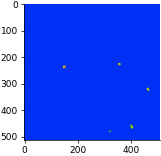

In [8]:
roi_map = skio.imread(os.path.join(data_dir, "ROIs.tif"))
plt.imshow(roi_map)

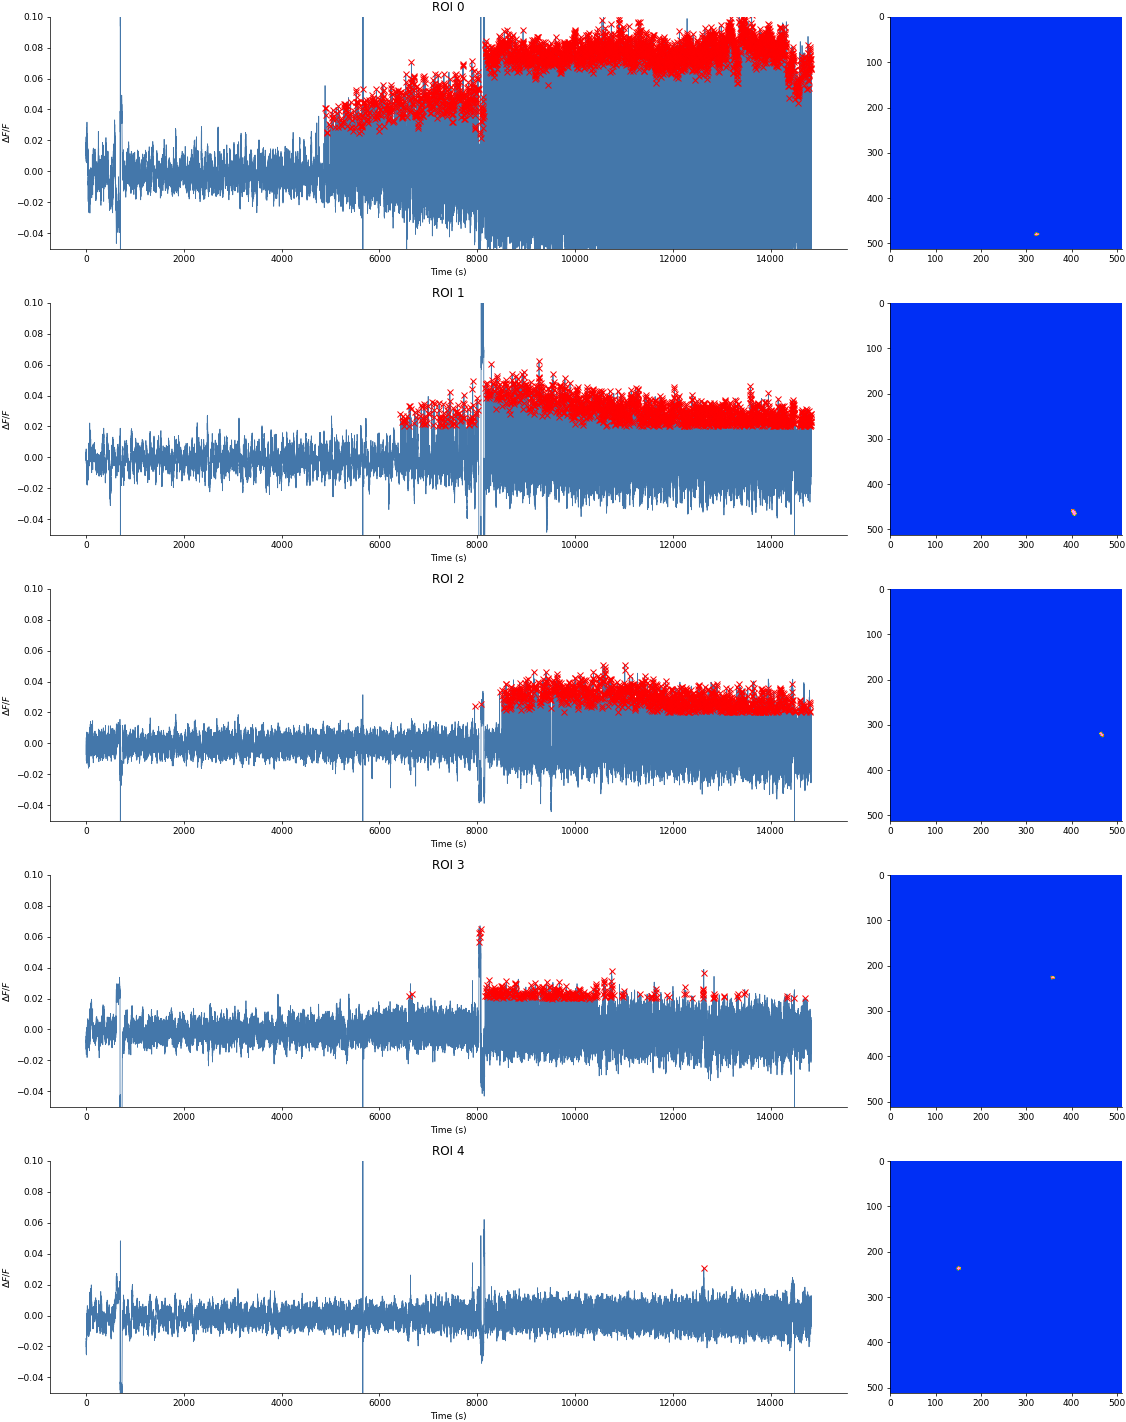

In [9]:
plt.close("all")
fig1, axes = dobj.plot_spikes_with_mask(roi_map)
for ax in axes[:,0]:
    ax.set_ylim(-0.05, 0.1)


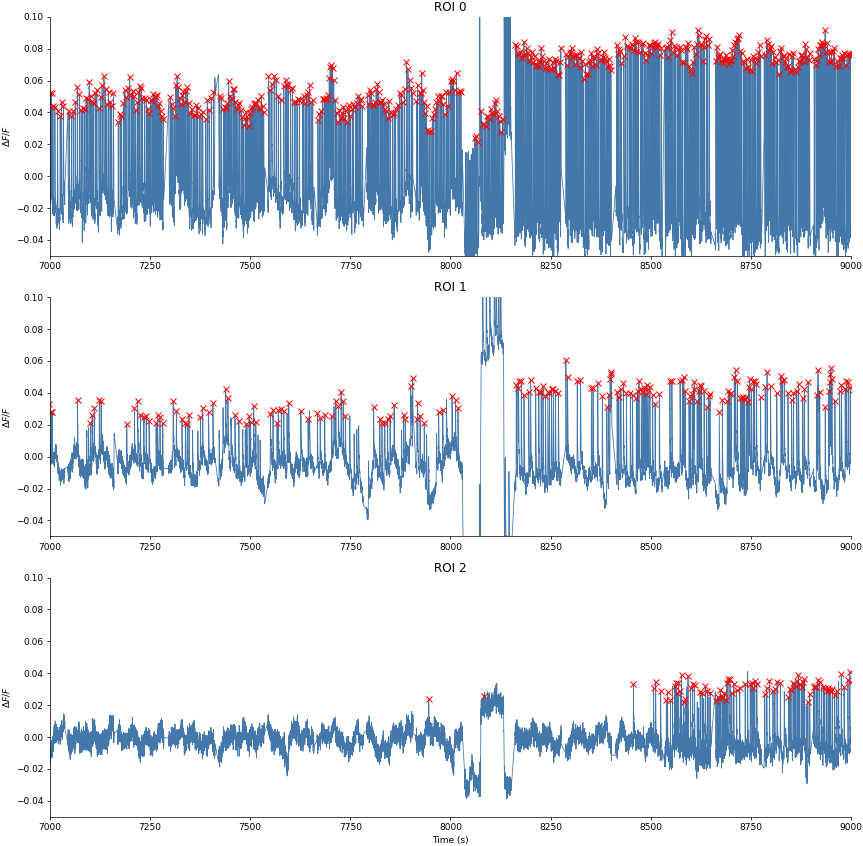

In [10]:
rois = np.array([0,1,2])
fig1, axes = dobj.plot_spikes(rois)
half_window = 1000
midpoint=8000
for idx, roi in enumerate(rois):
    axes[idx].set_xlim((midpoint-half_window, midpoint+half_window))
    axes[idx].set_ylim(-0.05, 0.1)


### Align embryos according to time of first spike

In [11]:
offset_times = []
isi_threshold = 120
rois = np.array([0,1,2])
for idx, roi in enumerate(rois):
    roi_data = dobj.peaks_data.loc[roi]
    isi = roi_data["isi"].to_numpy()
    # Find the first instance where two ISIs in a row are below the threshold
    offset_idx = np.argwhere((isi< isi_threshold)&(np.roll(isi, -1) < isi_threshold)).ravel()[0]
    offset_times.append(roi_data["t"].iloc[offset_idx])
dobj.peaks_data.loc[rois].to_csv(os.path.join(output_data_dir, "peaks_data.csv"))

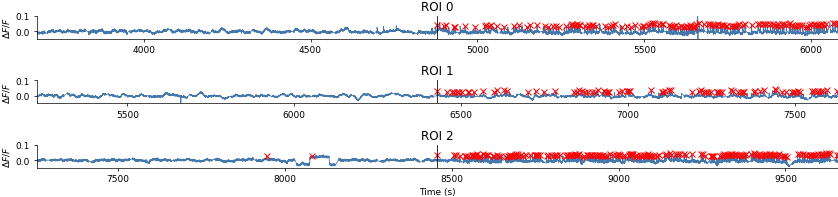

In [12]:
# Plot traces and detected spikes about the first spike detected
fig1, axes = dobj.plot_spikes(rois, figsize=(12,1))
half_window = 1200
for idx, roi in enumerate(rois):
    axes[idx].set_xlim((offset_times[idx]-half_window, offset_times[idx]+half_window))
    axes[idx].axvline(offset_times[idx], color="black")
    axes[idx].set_ylim(-0.05, 0.1)

### Check frequency change over developmental time for selected embryos

In [13]:
window_size=1800
droi, dsta, dststd = dobj.get_windowed_peak_stats(window_size, overlap=0.9, isi_stat_min_peaks=6)

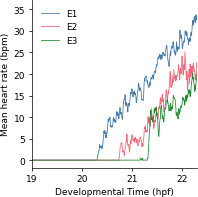

In [14]:
fig1, ax1 = plt.subplots(figsize=(3,3))
for roi in rois:
    e_data = droi.loc[roi]
    ax1.plot(e_data["hpf"], e_data["mean_freq"]*60, label= "E%d" % (roi+1))
ax1.set_xlim(19, 22.3)
ax1.legend()
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel("Mean heart rate (bpm)")
plt.tight_layout()
plt.savefig(os.path.join(output_data_dir, "heart_rate_abs_dev_time.svg"))
plt.savefig(os.path.join(output_data_dir, "heart_rate_abs_dev_time.png"), dpi=300)

In [15]:
all_offsets = []
for idx, roi in enumerate(rois):
    e_data = droi.loc[roi]
    hpf = np.array(e_data["hpf"])
    all_offsets.append(np.argwhere(e_data["offset"].to_numpy() >= offset_times[idx]).ravel()[0])

/tmp/ipykernel_132166/1236016006.py:32: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_132166/1236016006.py:56: RuntimeWarning: Mean of empty slice
  "mean_freq": np.nanmean(aligned_frequencies, axis=0), "hpf":hpf, \


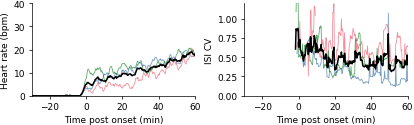

In [16]:
hpf = np.array(droi.loc[0]["hpf"])
hpf_offsets = hpf[all_offsets]
dt = hpf[1] - hpf[0]
aligned_frequencies = np.nan*np.ones((len(rois), \
                                      hpf.shape[0]+max(all_offsets)))
aligned_proms = np.zeros((len(rois), hpf.shape[0]+max(all_offsets)))
aligned_covs = np.nan*np.ones((len(rois), \
                                      hpf.shape[0]+max(all_offsets)))
unaligned_frequencies = np.zeros((len(rois), hpf.shape[0]))
unaligned_covs = np.zeros((len(rois), hpf.shape[0]))
unaligned_proms = np.zeros((len(rois), hpf.shape[0]))

for row, roi in enumerate(rois):
        e_data = droi.loc[roi]
        mean_freq = np.array(e_data["mean_freq"])
        cov = np.array(e_data["std_isi"]/e_data["mean_isi"])
        mean_prom = np.array(e_data["mean_prom"])
#         print(mean_freq.shape)
#         mean_freq = signal.filtfilt(b,a, mean_freq)
        start_idx = aligned_frequencies.shape[1] - e_data["hpf"].shape[0] - all_offsets[row]
        
        unaligned_frequencies[row, :] = mean_freq
        unaligned_proms[row, :] = mean_prom
        unaligned_covs[row,:] = cov
        
        aligned_frequencies[row, start_idx:start_idx+e_data["hpf"].shape[0]] = \
            mean_freq
        aligned_proms[row, start_idx:start_idx+e_data["hpf"].shape[0]] = mean_prom
        aligned_covs[row, start_idx:start_idx+e_data["hpf"].shape[0]] = cov
        
ts = (np.arange(aligned_frequencies.shape[1])-(aligned_frequencies.shape[1] - e_data["hpf"].shape[0]))*dt
mean_freq = np.nanmean(aligned_frequencies, axis=0)
mean_cv = np.nanmean(aligned_covs, axis=0)
std_freq = np.nanstd(aligned_frequencies, axis=0)
std_cv = np.nanstd(aligned_covs, axis=0)

fig1, axes = plt.subplots(1,2, figsize=(6,2))
axes[0].plot(ts*60, aligned_frequencies.T*60, alpha=0.75)
axes[1].plot(ts*60, aligned_covs.T, alpha=0.75)
axes[0].plot(ts*60, mean_freq*60, color="black", linewidth=1.5)
axes[1].plot(ts*60, mean_cv, color="black", linewidth=1.5)
axes[0].set_xlim(-30, 60)
axes[1].set_xlim(-30, 60)
axes[1].set_ylim(0, 1.2)
axes[0].set_ylim(0, 40)
axes[0].set_xlabel("Time post onset (min)")
axes[1].set_xlabel("Time post onset (min)")
axes[0].set_ylabel("Heart rate (bpm)")
axes[1].set_ylabel("ISI CV")
plt.tight_layout()
plt.savefig(os.path.join(output_data_dir, "agarose_encased_moments.svg"))
plt.savefig(os.path.join(output_data_dir, "agarose_encased_moments.png"))

savemat(os.path.join(output_data_dir, "all_moments.mat"), {"idx_offsets": all_offsets, \
            "all_freqs":unaligned_frequencies, "all_freqs_aligned":aligned_frequencies, \
            "mean_freq": np.nanmean(aligned_frequencies, axis=0), "hpf":hpf, \
            "proms": unaligned_proms, "proms_aligned": aligned_proms, "covs":unaligned_covs, "covs_aligned": aligned_covs,
                                                          "aligned_time_hpf": ts})